In [1]:
from face_swap_v2.image_preprocessing import *
from face_swap.keypoints import *
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import cv2

mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

source_img_path = "data/f1.jpg"
target_img_path = "data/macron2.jpg"

source_img = read_image(source_img_path)
target_img = read_image(target_img_path)

In [2]:
s_aligned, s_ldmks = align(source_img)
t_aligned, t_ldmks = align(target_img)

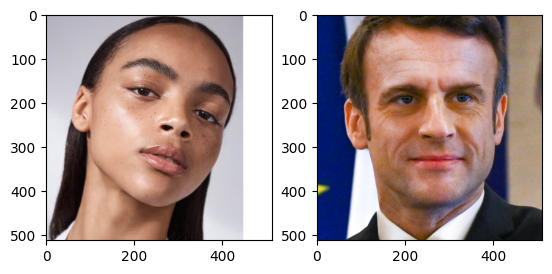

In [3]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(s_aligned)
axarr[1].imshow(t_aligned)

In [4]:
seam_clone = t_aligned.copy()
result = t_aligned.copy()
out_image = t_aligned.copy()
t_gray = cv2.cvtColor(t_aligned, cv2.COLOR_BGR2GRAY)
t_new_face = np.zeros_like(t_aligned)
seamlessclone = t_aligned.copy()

t_hull = cv2.convexHull(t_ldmks)

for i in range(0, int(len(TRIANGULATION) / 3)):
    triangle_index = [TRIANGULATION[i * 3], TRIANGULATION[i * 3 + 1], TRIANGULATION[i * 3 + 2]]
    tbas1 = s_ldmks[triangle_index[0]]
    tbas2 = s_ldmks[triangle_index[1]]
    tbas3 = s_ldmks[triangle_index[2]]
    triangle1 = np.array([tbas1, tbas2, tbas3], np.int32)
    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = s_aligned[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)
    

    points = np.array([[tbas1[0] - x, tbas1[1] - y],
                                               [tbas2[0] - x, tbas2[1] - y],
                                               [tbas3[0] - x, tbas3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)
    

    ttar1 = t_ldmks[triangle_index[0]]
    ttar2 = t_ldmks[triangle_index[1]]
    ttar3 = t_ldmks[triangle_index[2]]

    triangle2 = np.array([ttar1, ttar2, ttar3], np.int32)

    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[ttar1[0] - x, ttar1[1] - y],
                        [ttar2[0] - x, ttar2[1] - y],
                        [ttar3[0] - x, ttar3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h),borderMode=cv2.BORDER_REPLICATE)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = t_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255,
                                                                       cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle,
                                                              mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    t_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

img2_face_mask = np.zeros_like(t_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, t_hull, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

img2_head_noface = cv2.bitwise_and(seam_clone, seam_clone, mask=img2_face_mask)
result = cv2.add(img2_head_noface, t_new_face)

(x, y, w, h) = cv2.boundingRect(t_hull)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, seam_clone,
                                                          img2_head_mask, center_face2, cv2.MIXED_CLONE)

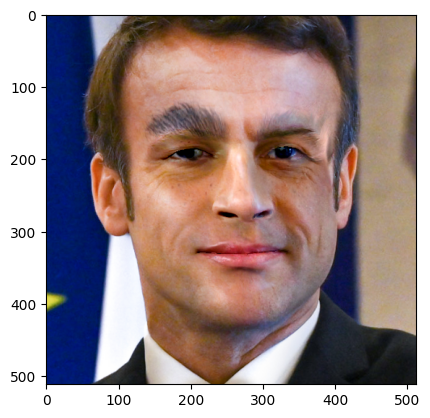

In [5]:
plt.imshow(seamlessclone)